In [4]:
cd ..

/playpen-raid1/tgreer/ICON


In [7]:
import training_scripts.brain_t1_pipeline.train as train
#import training_scripts.brain_t1_pipeline.train_quarter as trainq


from icon_registration import itk_wrapper
import itk
import matplotlib.pyplot as plt
import torch
import glob

In [32]:
ls /playpen-raid1/tgreer/InverseConsistency/training_scripts/brain_t1_pipeline/results

 brain_train/    'dermpy attempt lncc'/   quarter_stripped/     stripped/
 brain_train-1/   lncc.7/                 quarter_stripped-1/   stripped_rg.05/


In [16]:
net = train.make_network()
weights_path = "/playpen-raid1/tgreer/InverseConsistency/\
training_scripts/brain_t1_pipeline/results/stripped_rg.05/brain_aligner_resi_net30900"
net.regis_net.load_state_dict(torch.load(weights_path), strict=False)

_IncompatibleKeys(missing_keys=['identity_map', 'netPhi.identity_map', 'netPhi.net.identity_map', 'netPhi.net.netPhi.identity_map', 'netPhi.net.netPsi.identity_map', 'netPsi.identity_map'], unexpected_keys=['identityMap', 'netPhi.identityMap', 'netPhi.net.identityMap', 'netPhi.net.netPhi.identityMap', 'netPhi.net.netPhi.net.identityMap', 'netPhi.net.netPsi.identityMap', 'netPhi.net.netPsi.net.identityMap', 'netPsi.identityMap', 'netPsi.net.identityMap'])

In [33]:
net = train.make_network()
weights_path = "/playpen-raid1/tgreer/InverseConsistency/training_scripts/brain_t1_pipeline/results/lncc.7/knee_aligner_resi_net99900"
net.regis_net.load_state_dict(torch.load(weights_path), strict=False)

<All keys matched successfully>

In [16]:
net = trainq.make_network()
weights_path = "/playpen-raid1/tgreer/InverseConsistency/\
training_scripts/brain_t1_pipeline/results/quarter_stripped-1/brain_aligner_resi_net18000"
net.regis_net.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [17]:
ls /playpen-raid2/Data/HCP/manual_subcortical_segmentations_BWH/

101915/  131217/  140925/  149539/  163129/  199655/  298051/  672756/
123117/  133019/  146432/  149741/  188347/  201111/  397760/  751348/
124422/  133928/  147737/  153025/  189450/  208226/  414229/  856766/
126325/  135225/  148335/  159340/  190031/  211417/  499566/  857263/
130013/  138534/  149337/  162733/  198451/  212318/  654754/  899885/


In [55]:
def preprocess(image):
    #image = itk.CastImageFilter[itk.Image[itk.SS, 3], itk.Image[itk.F, 3]].New()(image)
    image = itk.shift_scale_image_filter(image, shift=0., scale = 1 / 1000)
    image = itk.clamp_image_filter(image, bounds=(0, 1))
    return image

NA = "101915"
NB = "131217"

#NA = "162733"
#NB = "198451"

NA = "149337"
NB = "201111"

image_A = itk.imread(
    f"/playpen-raid2/Data/HCP/HCP_1200/{NA}/T1w/T1w_acpc_dc_restore_brain.nii.gz")
image_A = preprocess(image_A)
image_B = itk.imread(
    f"/playpen-raid2/Data/HCP/HCP_1200/{NB}/T1w/T1w_acpc_dc_restore_brain.nii.gz")
image_B = preprocess(image_B)
image_A_seg = itk.imread(
    glob.glob(f"/playpen-raid2/Data/HCP/manual_subcortical_segmentations_BWH/{NA}/{NA}_*_novdc-label.nii.gz")[0])
image_B_seg = itk.imread(
    glob.glob(f"/playpen-raid2/Data/HCP/manual_subcortical_segmentations_BWH/{NB}/{NB}_*_novdc-label.nii.gz")[0])


In [56]:
phi_AB, phi_BA = itk_wrapper.register_pair(net, image_A, image_B, finetune_steps=50)

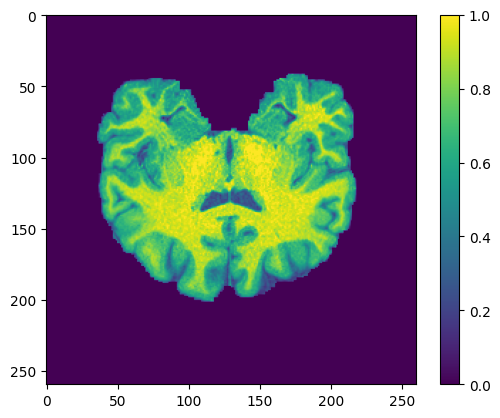

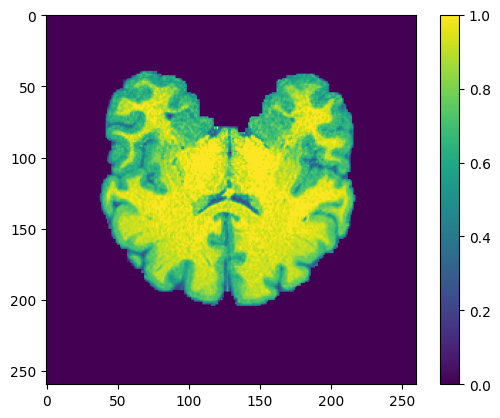

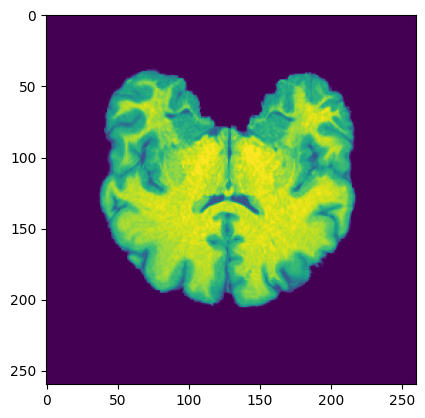

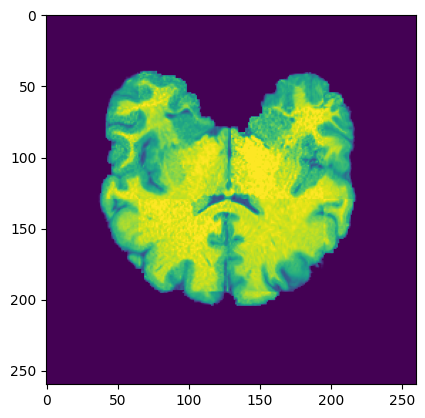

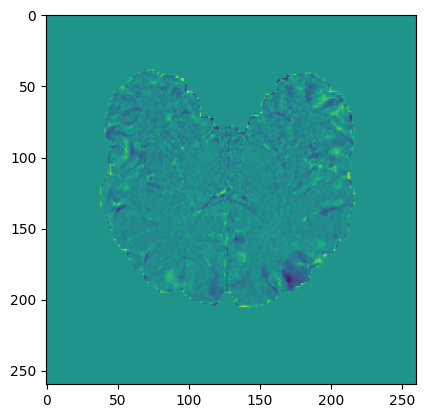

In [57]:
interpolator = itk.LinearInterpolateImageFunction.New(image_A)
warped_image_A = itk.resample_image_filter(image_A, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)

S = 170
plt.imshow(image_A[:, S])
plt.colorbar()
plt.show()
plt.imshow(image_B[:, S])
plt.colorbar()
plt.show()

plt.imshow(warped_image_A[:, S])
plt.show()

plt.imshow(itk.checker_board_image_filter(warped_image_A, image_B)[:, S])
plt.show()

plt.imshow(itk.subtract_image_filter(warped_image_A, image_B)[:, S])


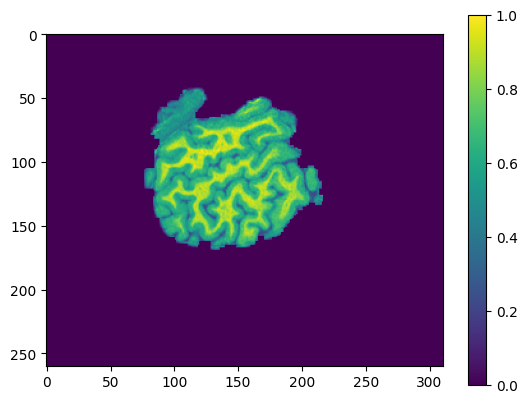

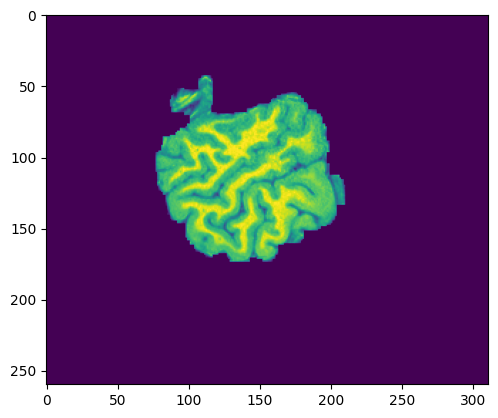

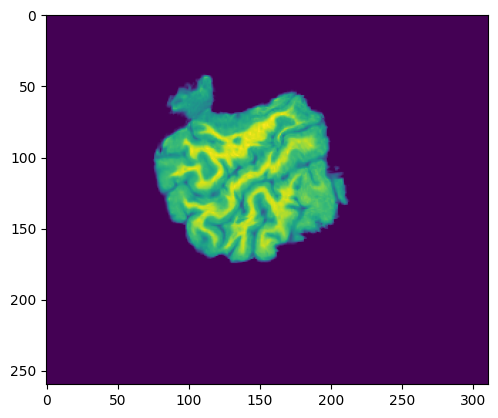

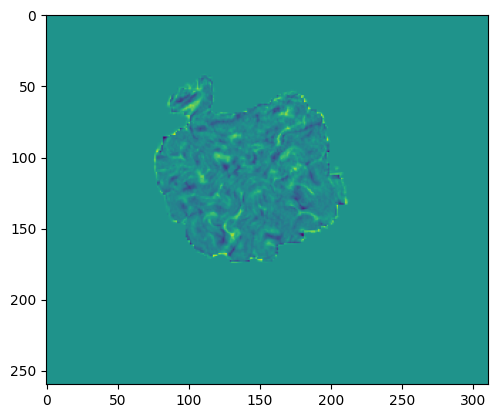

In [58]:
S = 205
plt.imshow(image_A[:, :, S])
plt.colorbar()
plt.show()
plt.imshow(image_B[:, :, S])
plt.show()

plt.imshow(warped_image_A[:, :, S])
plt.show()

#plt.imshow(itk.checker_board_image_filter(warped_image_A, image_B)[:, 90])
#plt.show()

plt.imshow(itk.subtract_image_filter(warped_image_A, image_B)[:,:, S])

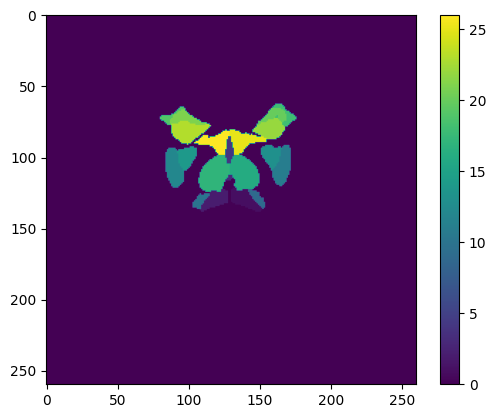

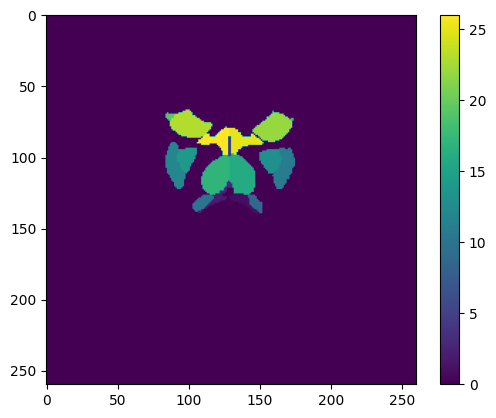

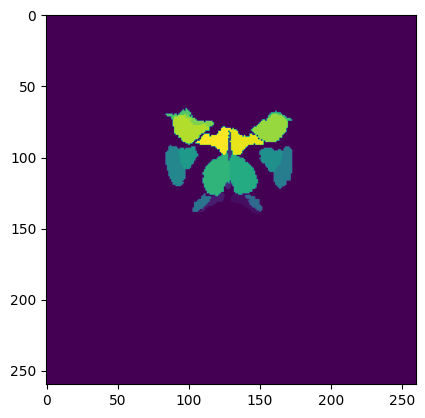

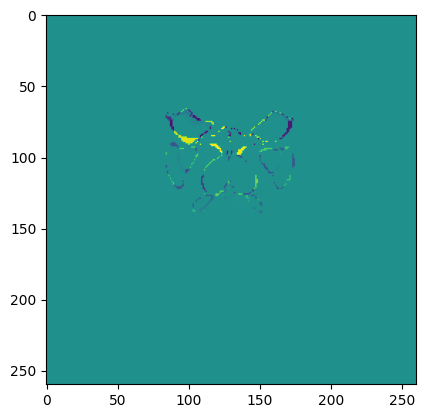

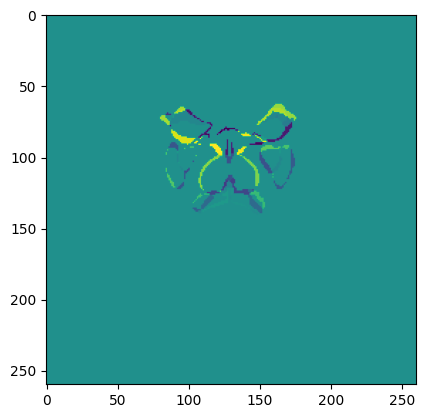

In [59]:
interpolator = itk.NearestNeighborInterpolateImageFunction.New(image_A_seg)
warped_image_A_seg = itk.resample_image_filter(image_A_seg, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)

S = 170
plt.imshow(image_A_seg[:, S])
plt.colorbar()
plt.show()
plt.imshow(image_B_seg[:, S])
plt.colorbar()
plt.show()

plt.imshow(warped_image_A_seg[:, S])
plt.show()

#plt.imshow(itk.checker_board_image_filter(warped_image_A_seg, image_B_seg)[:, S])
#plt.show()

plt.imshow(itk.subtract_image_filter(warped_image_A_seg, image_B_seg)[:, S])
plt.show()

plt.imshow(itk.subtract_image_filter(image_A_seg, image_B_seg)[:, S])


In [60]:
import numpy as np
def meanDICE(im1, im2):
    array1 = itk.array_from_image(im1)
    array2 = itk.array_from_image(im2)
    dices = []
    for index in range(1, max(np.max(array1), np.max(array2)) + 1):
        m1 = array1 == index
        m2 = array2 == index
        
        intersection = np.logical_and(m1, m2)
        
        d = 2 * np.sum(intersection) / (np.sum(m1) + np.sum(m2))
        dices.append(d)
    return np.mean(dices)
print(meanDICE(image_A_seg, image_B_seg))
print(meanDICE(warped_image_A_seg, image_B_seg))

0.5744065316665123
0.7864515370819353


In [39]:
meanDICE(warped_image_A_seg, image_B_seg)

0.7678324856685709

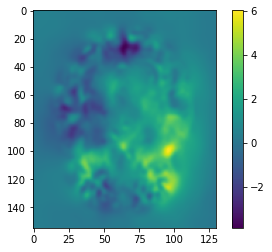

In [37]:
vf = phi_AB.GetNthTransform(1).GetParameters()
plt.imshow(np.array(vf).reshape(130, 155, 130, 3)[40, :, :, 2])
plt.colorbar()

In [36]:
vf = phi_AB.GetNthTransform(1).GetParameters()
plt.imshow(np.array(vf).reshape(65, 77, 65, 3)[20, :, :, 2])
plt.colorbar()

ValueError: cannot reshape array of size 7858500 into shape (65,77,65,3)

In [39]:
import pickle
import numpy as np
with open("training_scripts/brain_t1_pipeline/results/brain_train-1/loss_curve", "rb") as f:
    curve = pickle.load(f)
with open("training_scripts/brain_t1_pipeline/results/stripped_rg.05/loss_curve", "rb") as f:
    curve2 = pickle.load(f)

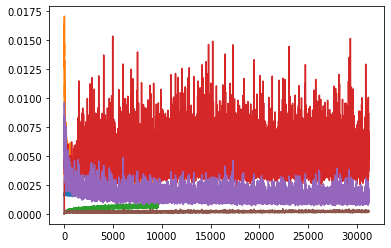

In [40]:
c = np.array([x[:3] for x in curve])
plt.plot(c)
c = np.array([x[:3] for x in curve2])
plt.plot(c)

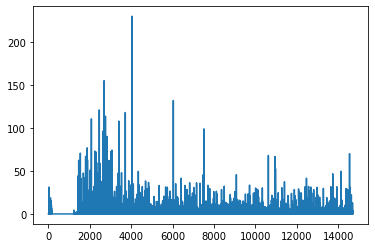

In [187]:
c = np.array([torch.mean(x[3].cpu()).item() for x in curve2])
plt.plot(c[:])

In [182]:
At = torch.tensor(np.array(image_A))[None, None]

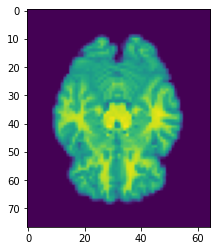

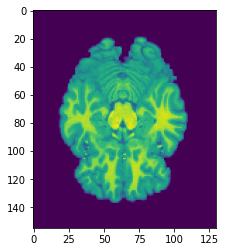

In [158]:
import torch.nn.functional as F
plt.imshow(F.avg_pool3d(At, 4)[0, 0, 20])
plt.show()
plt.imshow(F.avg_pool3d(At, 2)[0, 0, 40])